<a href="https://colab.research.google.com/github/saspav/DA-104/blob/main/hh_vacancy_resume_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Исследование динамики размещения вакансий и резюме на сайте hh.ru для ИТ-специализаций

In [1]:
__import__('warnings').filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import seaborn as sns

In [2]:
path_file = r'D:\проект_стажировкa'
name_file = 'vacancy_resume.csv'
file_csv = os.path.join(path_file, name_file)
if not os.access(file_csv, os.F_OK):
    file_csv = 'https://raw.githubusercontent.com/saspav/DA-104/main/dataset/vacancy_resume.zip'
df = pd.read_csv(file_csv, sep=';')
df[df.id == 1].head(7)

,date,id,specialization,vacancy_counts,resume_counts,category
0,2022-07-21,1,"Информационные технологии, интернет, телеком",84380,35033,"01-Информационные технологии, интернет, телеком"
28,2022-07-22,1,"Информационные технологии, интернет, телеком",83916,34884,"01-Информационные технологии, интернет, телеком"
56,2022-07-23,1,"Информационные технологии, интернет, телеком",82325,34887,"01-Информационные технологии, интернет, телеком"
84,2022-07-24,1,"Информационные технологии, интернет, телеком",80751,34974,"01-Информационные технологии, интернет, телеком"
112,2022-07-25,1,"Информационные технологии, интернет, телеком",82687,35106,"01-Информационные технологии, интернет, телеком"
140,2022-07-26,1,"Информационные технологии, интернет, телеком",84358,35112,"01-Информационные технологии, интернет, телеком"
168,2022-07-27,1,"Информационные технологии, интернет, телеком",84094,35123,"01-Информационные технологии, интернет, телеком"


In [3]:
def show_graph(sdf, kind):
    params = {0: ('вакансий', 'g'), 1: ('резюме', 'orange')}
    sdf.set_index('date', inplace=True)
    sdf.columns = ['counts']
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.set_title(f'Количество публикаций {params[kind][0]} по датам', size=18)
    ax.plot(sdf.index, sdf.counts, color=params[kind][1])
    ax.grid()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=7)
    plt.show()

#### Посмотрим на графики публикации предложений

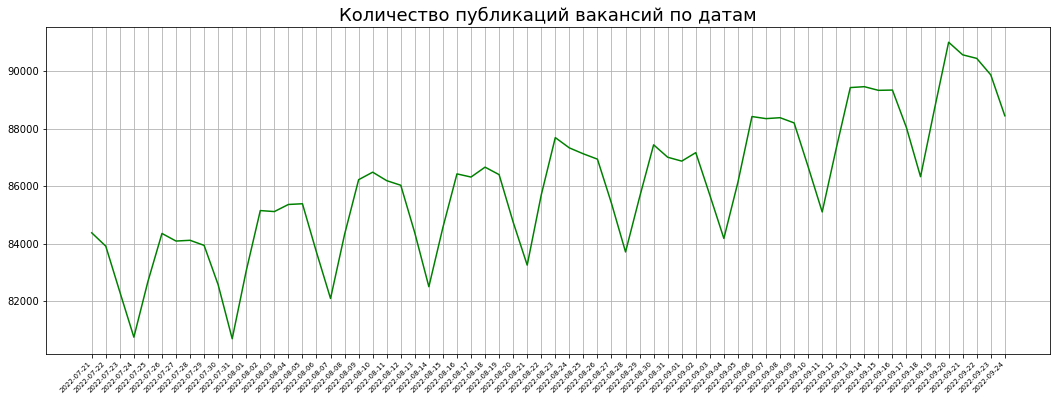

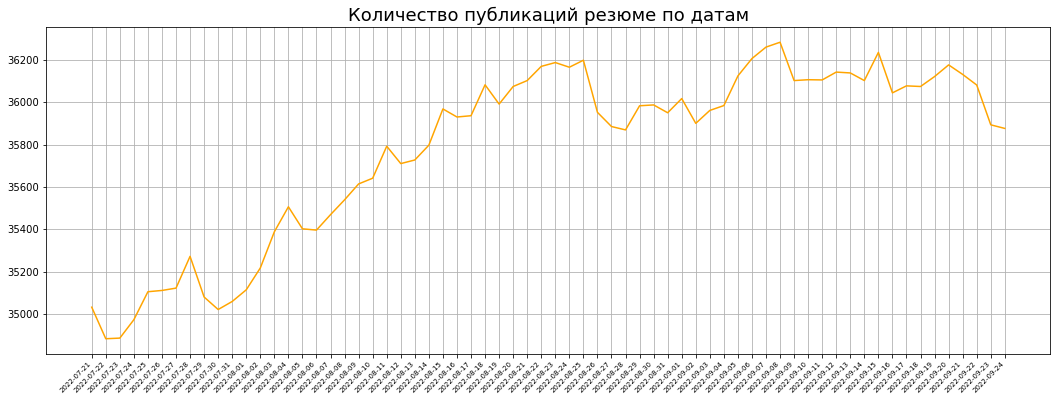

In [4]:
show_graph(df[df.id == 1][['date', 'vacancy_counts']], 0)
show_graph(df[df.id == 1][['date', 'resume_counts']], 1)

##### Можно предположить, что на обоих графиках прослеживается тренд по увеличению количества предложений с течением времени. Проверим оба временных ряда на стационарность с помощью теста Дики-Фуллера:

Это статистический тест, специально созданный для проверки того, являются ли
одномерные данные временных рядов стационарными или нет.
Этот тест основан на гипотезе и может сообщить нам степень вероятности,
с которой она может быть принята. Он часто классифицируется по одному
из тестов unit root, он определяет, насколько сильно одномерные данные
временных рядов следуют тренду.
Давайте определим нулевую и альтернативные гипотезы:

- Ho (нулевая гипотеза): данные временных рядов нестационарны

- H1 (альтернативная гипотеза): данные временных рядов являются стационарными

Возьмем альфа = 5%, что означает (95% достоверности).
Результаты теста интерпретируются с p-значением:
если p > 0,05 не отклоняем нулевую гипотезу, 
иначе, если p <= 0,05 отклоняем нулевую гипотезу.
Теперь протестируем данные с помощью статистической функции adfuller(),
предоставляемой пакетом stats model, чтобы проверить, являются ли данные
стационарными или нет.

In [5]:
def check_stationary(sdf, kind):
    alpha = 5
    params = {0: 'вакансий', 1: 'резюме'}
    result = adfuller(sdf)[1]
    print(f'p-value для {params[kind]}: {result}')
    if result < alpha / 100:
        print(f'Отвергаем нулевую гипотезу: '
              f'временной ряд стационарен с вероятностью {100 - alpha}%')
    else:
        print(f'Принимаем нулевую гипотезу: '
              f'временной ряд НЕ стационарен с вероятностью {100 - alpha}%')

In [6]:
check_stationary(df[df.id == 1][['vacancy_counts']], 0)

p-value для вакансий: 0.8360036030134257
Принимаем нулевую гипотезу: временной ряд НЕ стационарен с вероятностью 95%


In [7]:
check_stationary(df[df.id == 1][['resume_counts']], 1)

p-value для резюме: 0.16775711422444506
Принимаем нулевую гипотезу: временной ряд НЕ стационарен с вероятностью 95%


#### Тест Дики-Фуллера показал, что динамика размещения вакансий и резюме имеет тренд увеличения количества предложений с течением времени. Так же на графике видно, что размещение вакансий имеет сезонный характер с периодом в неделю. 
#### Рассмотрим это подробнее:

In [14]:
def show_trend(sdf, kind):
    params = {0: ('вакансий', 'g'), 1: ('резюме', 'orange')}
    sdf.set_index('date', inplace=True)
    sdf.columns = ['counts']
    #произведем декомпозицию временного ряда 
    decomposition = seasonal_decompose(sdf, period=7)
    fig = decomposition.plot(observed=False, resid=False)
    fig.axes[0].set_title(f'Количество публикаций {params[kind][0]} по датам', size=18)
    fig.set_size_inches((18, 12))
    labels = ['Тренд', 'Сезонность']
    for i, ax in enumerate(fig.axes):
        ax.set_ylabel(labels[i], fontsize=20)
        ax.grid()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    fig.tight_layout() 
    plt.show()

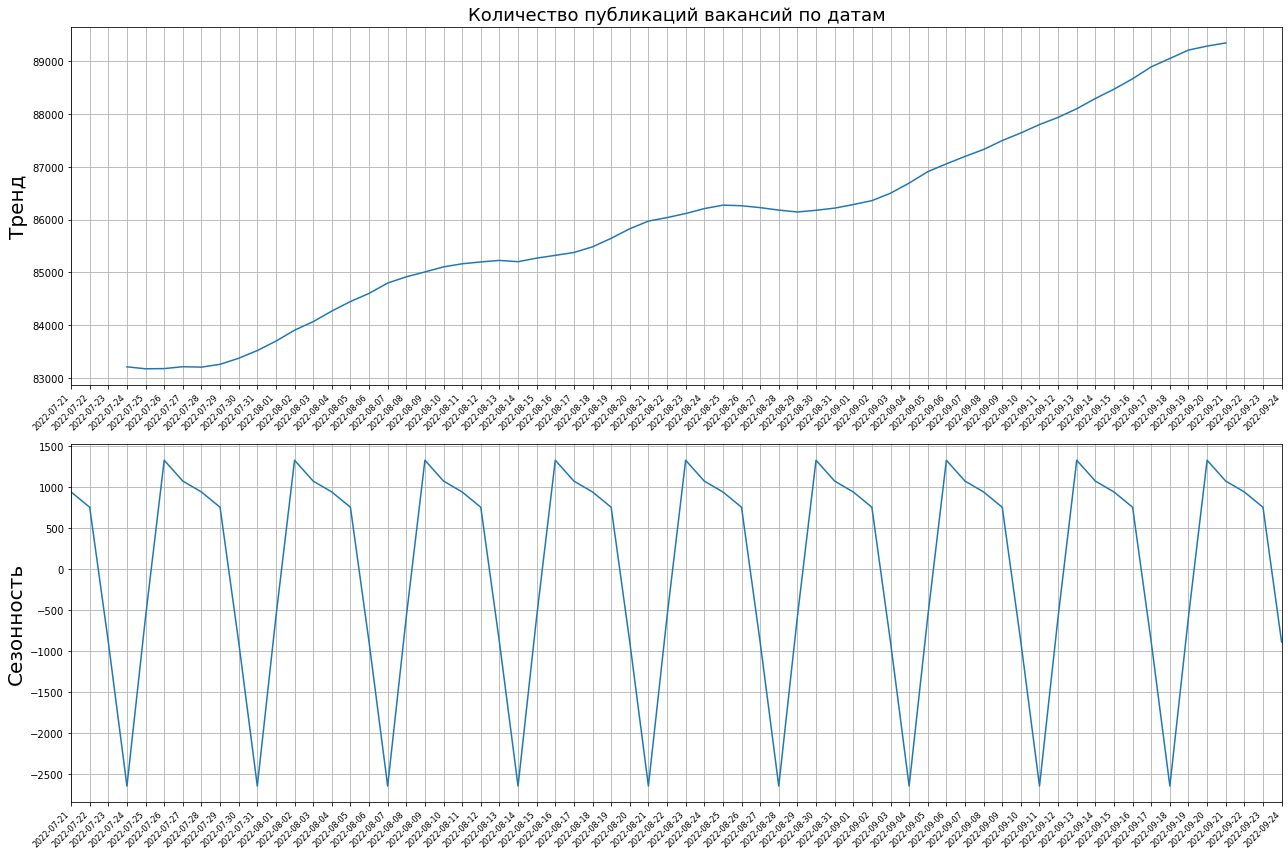

In [15]:
show_trend(df[df.id == 1][['date', 'vacancy_counts']], 0)

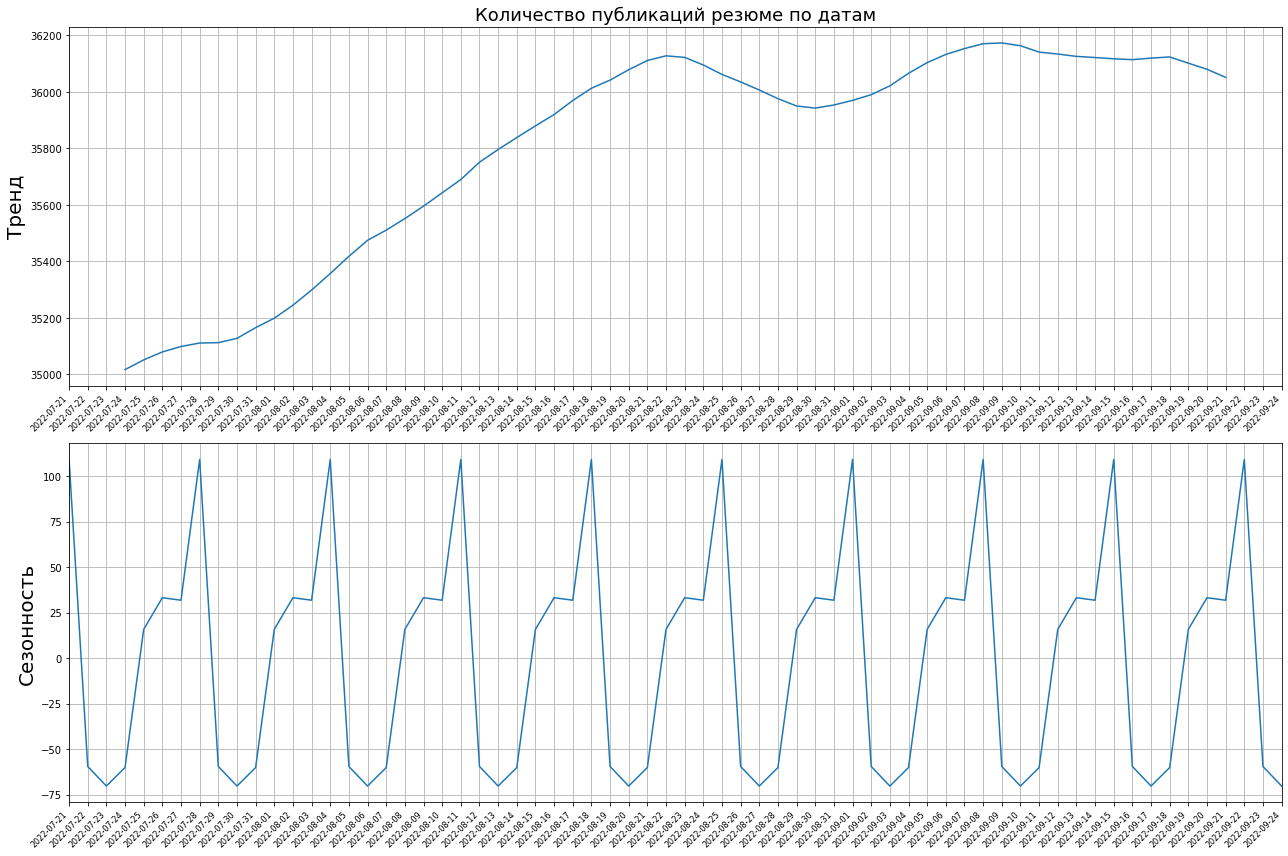

In [16]:
show_trend(df[df.id == 1][['date', 'resume_counts']], 1)